# 데이터 정보

| **항목**            | **내용**         |  
| ------------------ | ---------------- |
| **데이터 Modality** | CT               | 
| **데이터 타입**      | 이미지            |
| **데이터 컨테이너**   |.jpg              |
| **데이터 해상도**     | 512 × 512 (픽셀) |
| **데이터 비트타입**   | 8bit             |

* 원본: MRI 또는 CT 스캔 이미지 (정확한 모달리티는 데이터셋마다 상이)

* 클래스: 주로 'positive (종양 있음)' 또는 'negative (종양 없음)'의 이진 분류 또는 특정 종양 유형 (Glioma, Meningioma, Pituitary tumor, No Tumor)으로 분류됩니다.

* 포맷: YOLO 학습에 적합한 .txt 어노테이션 파일과 이미지 파일로 구성됩니다.

* 구성: 학습, 검증, 테스트 세트로 나뉘어 있으며, 각 세트별 이미지 수와 어노테이션 정보가 명시됩니다.


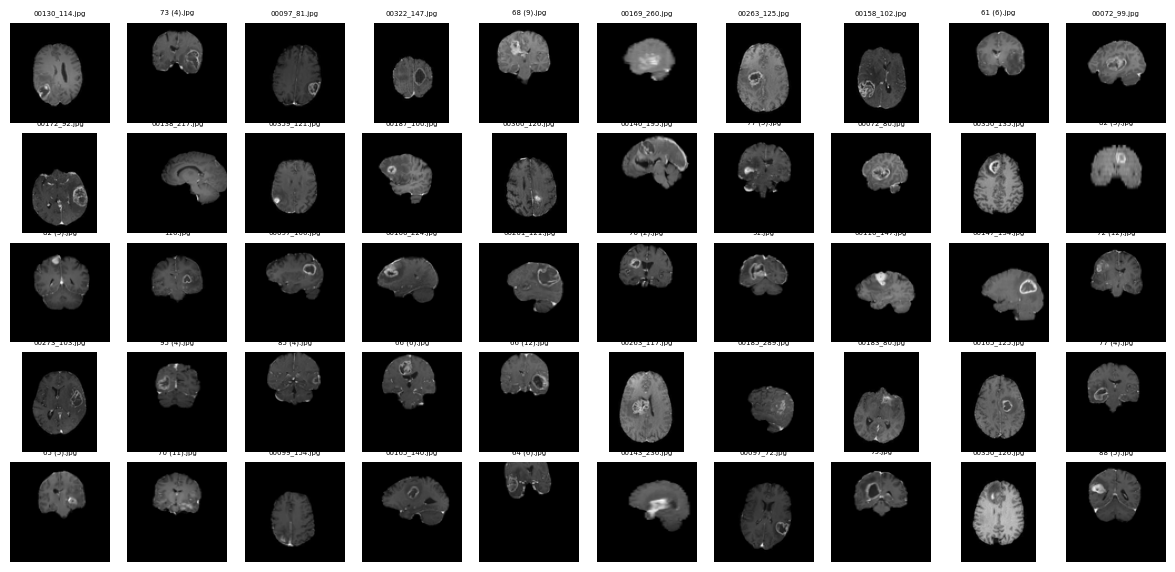

In [2]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# 이미지 폴더 경로 
image_folder = r"dataset/brain-tumor/train/images"

# 이미지 파일 리스트
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sample_count = 50
if len(image_files) < sample_count:
    sample_count = len(image_files)

sample_files = random.sample(image_files, sample_count)

cols, rows = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))  # 전체 크기 줄임
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    if i < sample_count:
        img_path = os.path.join(image_folder, sample_files[i])
        img = Image.open(img_path)
        img = img.convert("RGB")

        base_width = 90
        w_percent = (base_width / float(img.size[0]))
        h_size = int((float(img.size[1]) * float(w_percent)))

        try:
            resample_mode = Image.Resampling.LANCZOS
        except AttributeError:
            resample_mode = Image.ANTIALIAS

        img = img.resize((base_width, h_size), resample_mode)

        ax.imshow(img)
        ax.set_title(sample_files[i], fontsize=5)
    ax.axis('off')

# 데이터셋 구성

   **뇌종양 데이터셋 구성**

| 세트 구분  | 이미지 수   |
| ------ | ---------   |
| 훈련 세트  | 893개   |
| 테스트 세트 | 223개  |
| **총합** | **1,116개**  |

  **클래스 구성**

| 클래스 이름        | 설명                  |
| ------------- | ------------------- |
| 음성 (Negative: 0) | 뇌종양이 없는 이미지         |
| 양성 (Positive: 1) | 뇌종양이 있는 이미지 (병변 포함) |


**훈련데이터 클래스별 구성**

In [4]:
import os
import numpy as np
from collections import defaultdict

# 경로 설정
label_folder = 'dataset/brain-tumor/train/labels'      # YOLO 라벨(.txt) 파일 폴더
images_folder = 'dataset/brain-tumor/train/images'     # 이미지 파일 폴더

# 클래스별 수량 저장용
class_counts = defaultdict(int)
unlabeled_count = 0

# 이미지 파일 리스트
image_files = [f for f in os.listdir(images_folder)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 라벨 파일 리스트
label_files_set = set(f for f in os.listdir(label_folder) if f.endswith('.txt'))

for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]
    label_file = base_name + '.txt'
    label_path = os.path.join(label_folder, label_file)

    if label_file in label_files_set:
        try:
            data = np.loadtxt(label_path, ndmin=2)  # YOLO format: class x y w h
            classes = data[:, 0].astype(int)
            for cls in classes:
                class_counts[cls] += 1
        except Exception as e:
            print(f"{label_file} 처리 중 오류 발생: {e}")
    else:
        unlabeled_count += 1

# 결과 출력
print(f"{'Class Index':<15}{'Count'}")
print("-" * 30)
for cls, count in sorted(class_counts.items()):
    print(f"{cls:<15}{count}")
print(f"{'No Label Files':<15}{unlabeled_count}")

Class Index    Count
------------------------------
0              437
1              488
No Label Files 15


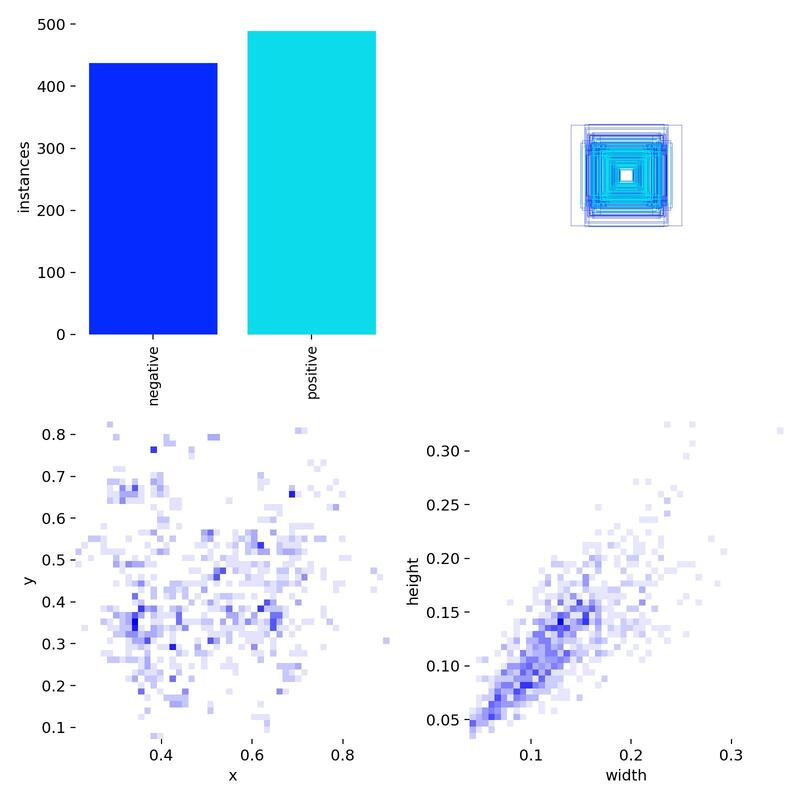


**클래스별 이미지 예시**

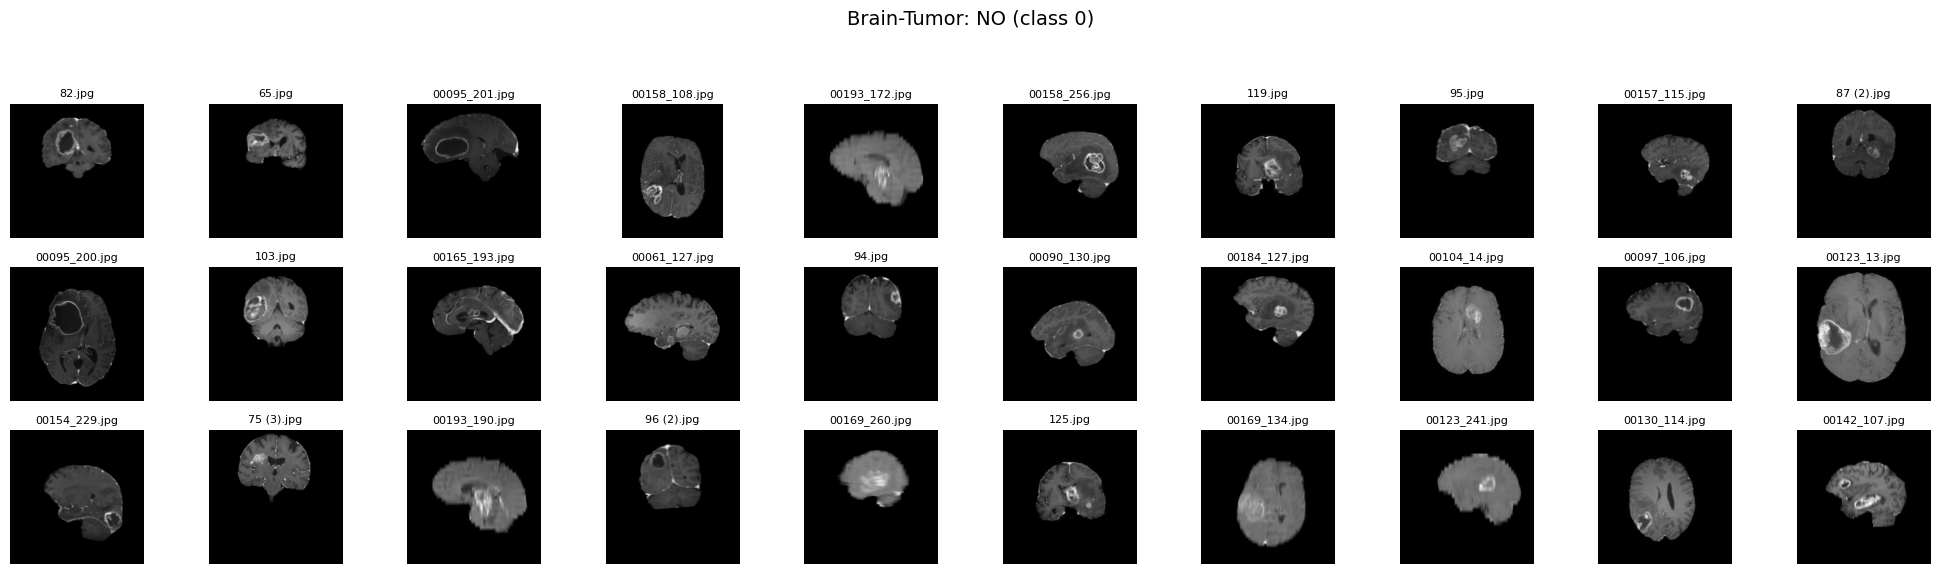

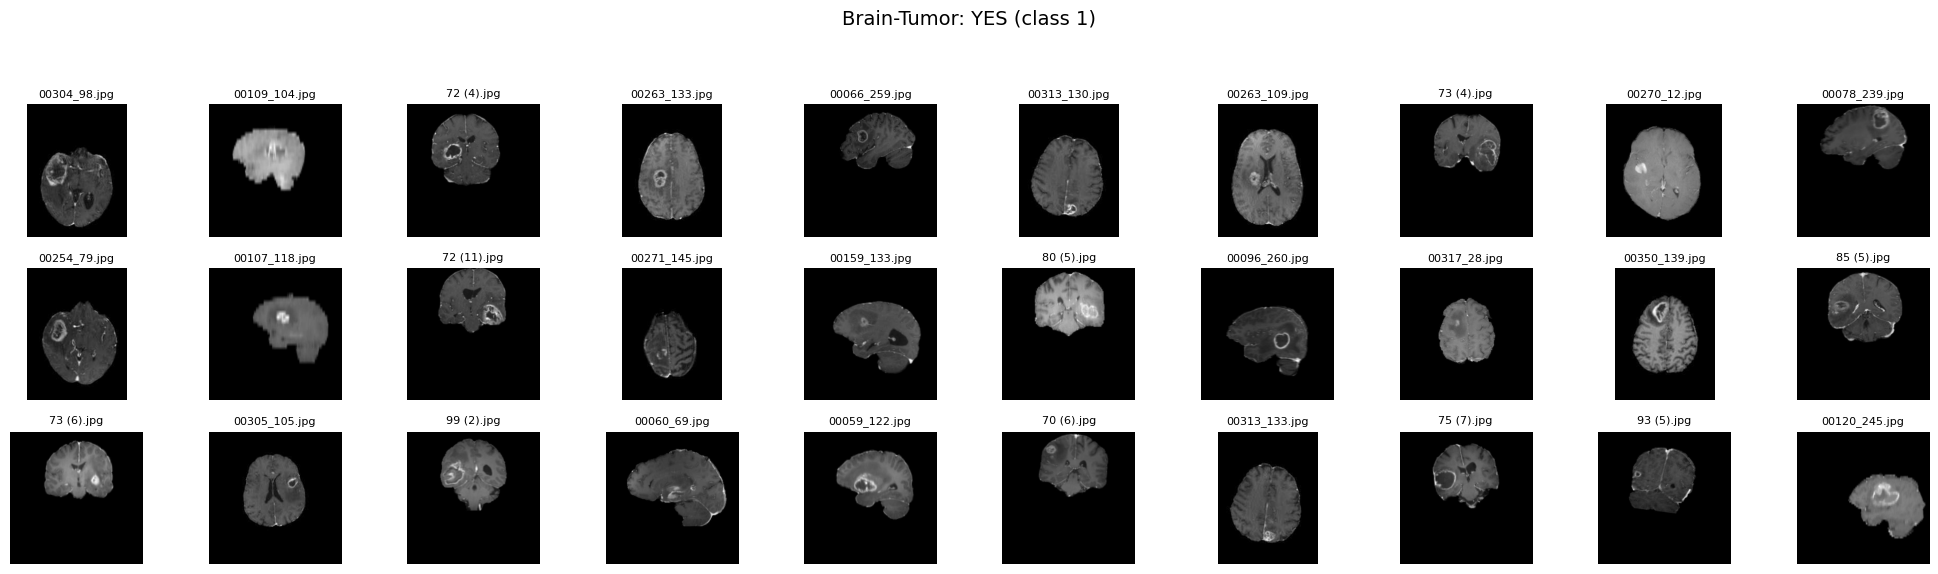

In [5]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
# 경로 설정
image_folder = 'dataset/brain-tumor/train/images'
label_folder = 'dataset/brain-tumor/train/labels'

# 클래스별 이미지 매핑 딕셔너리
class_to_images = {}

# 모든 라벨 파일 순회
label_files = [f for f in os.listdir(label_folder) if f.endswith('.txt')]
for label_file in label_files:
    label_path = os.path.join(label_folder, label_file)
    base_name = os.path.splitext(label_file)[0]
    
    # 이미지 확장자 대응 (.jpg, .png, etc.)
    possible_extensions = ['.jpg', '.png', '.jpeg']
    image_path = None
    for ext in possible_extensions:
        temp_path = os.path.join(image_folder, base_name + ext)
        if os.path.exists(temp_path):
            image_path = temp_path
            break
    if image_path is None:
        continue

    try:
        labels = np.loadtxt(label_path, ndmin=2)
        class_ids = labels[:, 0].astype(int)
        for cls in np.unique(class_ids):
            class_to_images.setdefault(cls, []).append(image_path)
    except Exception as e:
        print(f"[오류] {label_file} 처리 실패: {e}")

# ✅ 클래스 이름 매핑
class_titles = {
    0: "Brain-Tumor: NO (class 0)",
    1: "Brain-Tumor: YES (class 1)"
}

# ✅ 시각화 함수
def show_class_images_grid(class_index, image_paths, max_images=30, cols=10, rows=3):
    sampled = random.sample(image_paths, min(len(image_paths), max_images))

    plt.figure(figsize=(cols * 2, rows * 2))
    for i, img_path in enumerate(sampled):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path), fontsize=8)
        plt.axis('off')

    title = class_titles.get(class_index, f"Class {class_index}")
    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

# ✅ 모든 클래스에 대해 시각화 실행
for cls, img_list in sorted(class_to_images.items()):
    if len(img_list) < 1:
        continue
    show_class_images_grid(cls, img_list, max_images=30, cols=10, rows=3)


# Yolo 형식의 객체탐지 라벨 형식

**예시 라벨: 1 0.344484 0.342723 0.221831 0.176056**


| 항목         | 값                   | 의미                                   |
| ---------- | ------------------- | ------------------------------------ |
| `1`        | 클래스 ID              | 해당 객체가 클래스 1에 해당함                    |
| `0.344484` | 중심 x 좌표 (x\_center) | 이미지 너비의 비율로 표현된 중심점 x (예: 34.4%)     |
| `0.342723` | 중심 y 좌표 (y\_center) | 이미지 높이의 비율로 표현된 중심점 y (예: 34.3%)     |
| `0.221831` | 너비 (width)          | 이미지 너비의 비율로 표현된 바운딩 박스 너비 (예: 22.2%) |
| `0.176056` | 높이 (height)         | 이미지 높이의 비율로 표현된 바운딩 박스 높이 (예: 17.6%) |


**라벨링 시각화 예시**

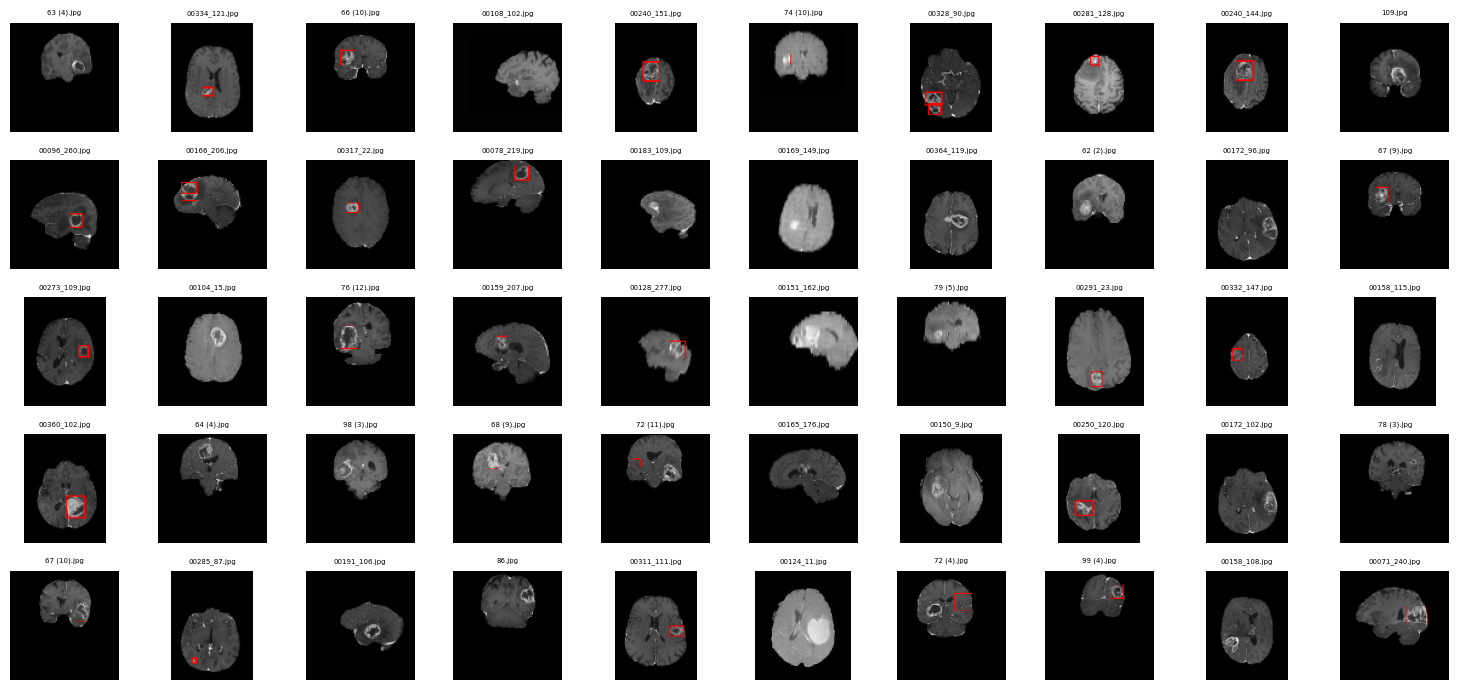

In [6]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# 경로 (본인 환경에 맞게 변경)
image_folder = r"dataset/brain-tumor/train/images"
label_folder = r"dataset/brain-tumor/train/labels"

# 이미지 리스트
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

sample_count = 50
if len(image_files) < sample_count:
    sample_count = len(image_files)

sample_files = random.sample(image_files, sample_count)

cols, rows = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 7))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, ax in enumerate(axes.flat):
    if i >= sample_count:
        ax.axis('off')
        continue

    img_name = sample_files[i]
    img_path = os.path.join(image_folder, img_name)
    label_name = os.path.splitext(img_name)[0] + '.txt'
    label_path = os.path.join(label_folder, label_name)

    # 이미지 읽기 (OpenCV는 BGR)
    img = cv2.imread(img_path)
    if img is None:
        ax.axis('off')
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    # 라벨 읽어서 박스 그리기
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x_c, y_c, bw, bh = parts
                if cls != '1':  # positive class만 박스 그림
                    continue
                x_c, y_c, bw, bh = map(float, [x_c, y_c, bw, bh])

                # YOLO 형식 중심좌표->절대좌표 변환
                xmin = int((x_c - bw / 2) * w)
                ymin = int((y_c - bh / 2) * h)
                xmax = int((x_c + bw / 2) * w)
                ymax = int((y_c + bh / 2) * h)

                # 박스 그리기 (빨간색, 두께 2)
                cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # 이미지 크기 조정 (가로 90픽셀)
    base_width = 90
    scale_ratio = base_width / w
    new_h = int(h * scale_ratio)
    img = cv2.resize(img, (base_width, new_h))

    ax.imshow(img)
    ax.set_title(img_name, fontsize=5)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Ⅰ. CT 데이터의 특성

## 1. 의료 영상의 특성

*   모달리티 (Modality): 대부분의 뇌종양 데이터셋은 MRI (자기공명영상) 또는 CT (컴퓨터 단층 촬영) 이미지로 구성됩니다. MRI는 연부 조직 대조도가 뛰어나 뇌 조직과 종양을 구별하는 데 유리하며, CT는 뼈와 출혈을 잘 보여줍니다.
*   그레이 스케일 이미지 (Grayscale Images): 일반적으로 흑백 이미지로 구성되며, 각 픽셀 값은 HU (Hounsfield Unit) (CT의 경우) 또는 특정 신호 강도 (MRI의 경우)를 나타냅니다.
*   다양한 촬영 슬라이스 (Multiple Slices): 뇌종양은 3차원 구조이므로, 일반적으로 여러 장의 2D 슬라이스로 구성된 시리즈 형태로 제공됩니다. YOLO는 주로 2D 이미지에 적용되지만, 3D 데이터를 2D 슬라이스로 분할하거나, 각 슬라이스에 YOLO를 적용한 후 3D 재구성하는 방식이 사용됩니다.

## 2. 뇌종양 특성을 반영한 어노테이션



*   클래스 정의: 데이터셋에 따라 뇌종양의 종류(예: Glioma, Meningioma, Pituitary tumor)를 세분화하거나, 단순히 '종양' 또는 '정상/비정상'으로 분류하는 경우가 있습니다. 어떤 데이터셋은 '종양 없음(No Tumor)' 클래스도 포함합니다.

*   바운딩 박스 정확도: 의료 영상에서 종양의 정확한 위치를 바운딩 박스로 표시하는 것은 매우 중요합니다. 어노테이션의 품질은 모델의 탐지 성능에 직접적인 영향을 미칩니다.
*   작은 객체 (Small Objects): 초기 단계의 종양은 매우 작을 수 있습니다. YOLO 모델은 작은 객체 탐지에 어려움을 겪을 수 있으므로, 이러한 데이터셋에서는 FPN(Feature Pyramid Network)과 같은 기술을 활용하여 다양한 스케일의 특징을 학습하도록 합니다.

## 3. 데이터셋 크기 및 다양성

* 뇌종양 데이터셋은 수백 장에서 수천 장의 이미지로 구성될 수 있습니다. 데이터셋의 크기와 다양성(환자 수, 종양의 크기, 모양, 위치 다양성)은 모델의 강건성을 높이는 데 중요합니다.

* 클래스 불균형 (Class Imbalance): 정상 이미지에 비해 종양 이미지가 적거나, 특정 유형의 종양이 다른 유형보다 훨씬 적게 나타나는 클래스 불균형 문제가 있을 수 있습니다. 이는 모델 학습 시 고려되어야 합니다.

# Ⅲ. 뇌종양 이미지데이터 전처리



의료용 데이터, 특히 영상 데이터(예: MRI, CT, X-ray, 병리 이미지 등)는 일반 이미지와는 달리 임상적으로 중요한 특징을 담고 있기 때문에 전처리 과정에서 매우 신중해야 합니다.

| 기법명                       | 설명                               | 함수명                        |
| ------------------------- | -------------------------------- | -------------------------- |
| **Z-score 정규화**           | 이미지 픽셀 값을 평균 0, 표준편차 1로 스케일링     | `normalize_zscore()`       |
| **CLAHE (적응형 히스토그램 평활화)** | 국소 대비 향상, 의료 영상에서 유용             | `apply_clahe()`            |
| **가우시안 블러**               | 노이즈 제거 및 부드럽게 처리, 데이터 증강용        | `apply_gaussian_blur()`    |
| **샤프닝 필터**                | 경계 및 세부 구조 강조                    | `sharpen_image()`          |
| **밝기 조절**                 | 이미지 밝기 증가, 데이터 증강용               | `adjust_brightness()`      |
| **히스토그램 평활화**             | 이미지 전체 대비 향상 (밝기 분포 균일화)         | `histogram_equalization()` |
| **가우시안 노이즈 추가**           | Gaussian Noise 추가로 모델의 일반화 능력 향상 | `add_gaussian_noise()`     |


[INFO] 선택된 파일: 00158_239.jpg


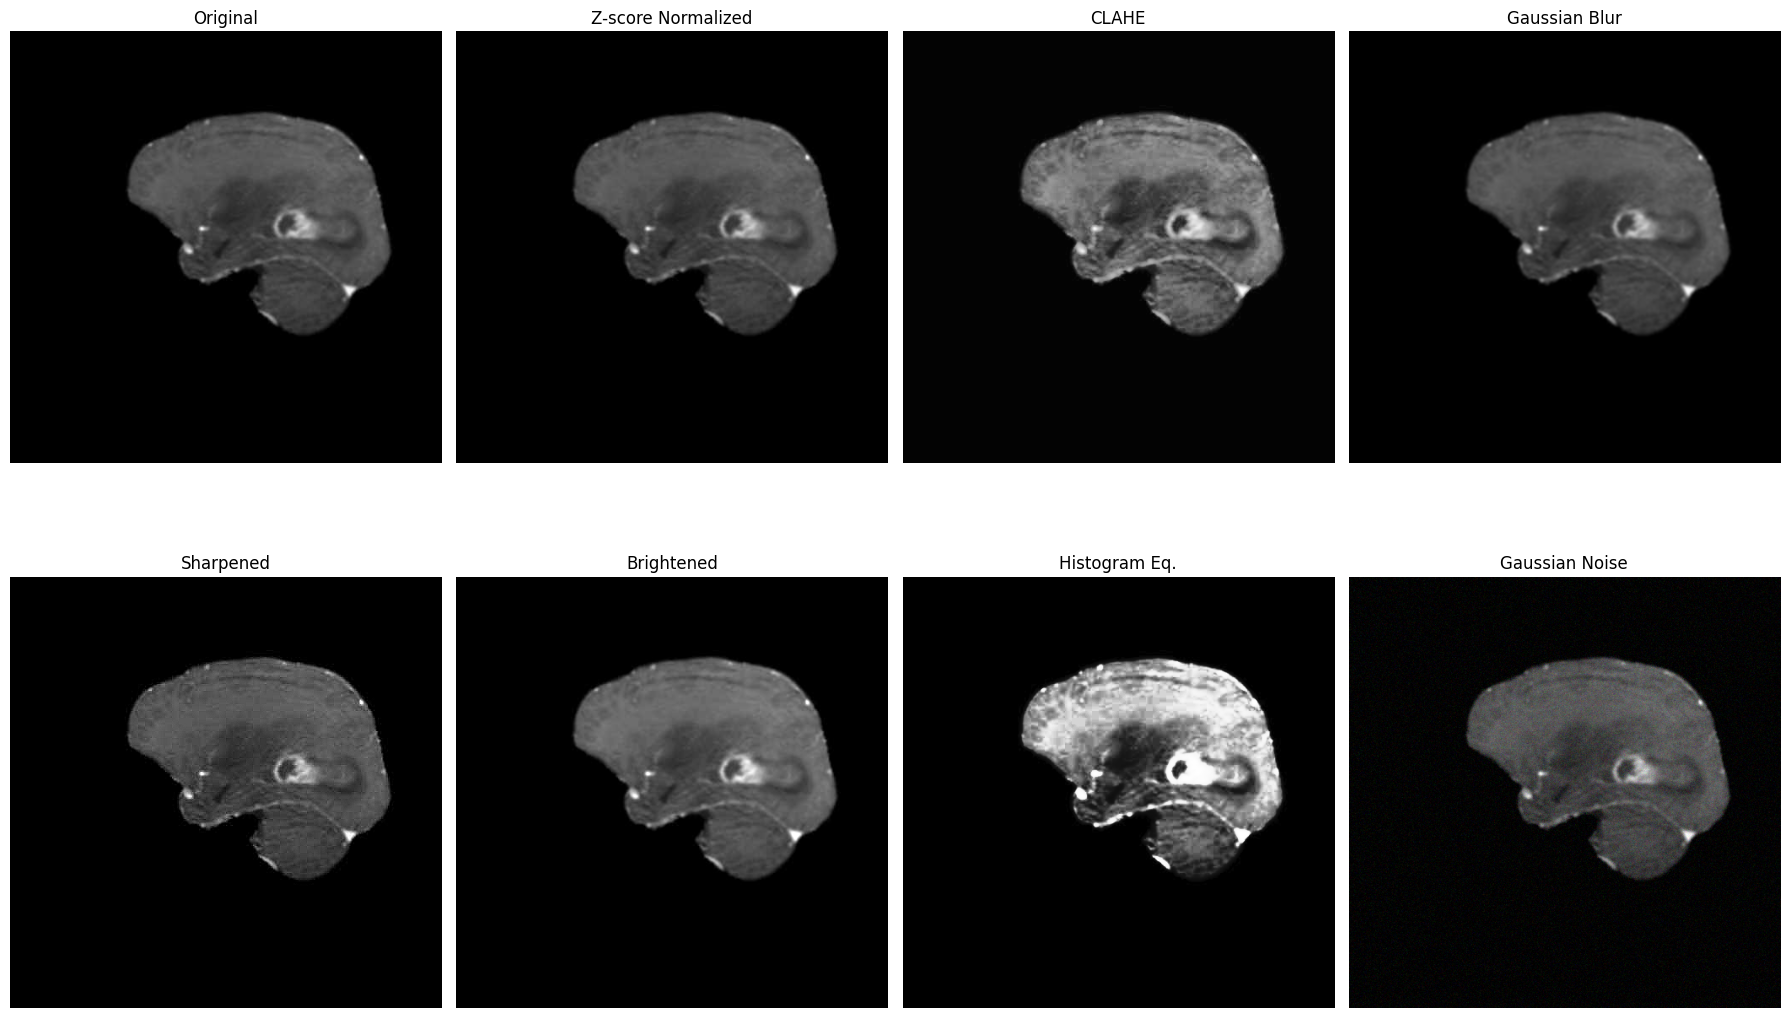

In [9]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

# 전처리 함수들
def normalize_zscore(img):
    img = img.astype(np.float32)
    mean = np.mean(img)
    std = np.std(img) + 1e-8
    norm = (img - mean) / std
    norm = cv2.normalize(norm, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return norm

def apply_clahe(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

def apply_gaussian_blur(img, ksize=(3, 3)):
    return cv2.GaussianBlur(img, ksize, 0)

def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def adjust_brightness(img, factor=1.2):
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Brightness(pil_img)
    bright_img = enhancer.enhance(factor)
    return cv2.cvtColor(np.array(bright_img), cv2.COLOR_RGB2BGR)

def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def add_gaussian_noise(img, mean=0, std=10):
    noise = np.random.normal(mean, std, img.shape).astype(np.float32)
    noisy = img.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

# 시각화 함수
def show_processed_variants(image_input_folder):
    # 이미지 파일 목록
    image_files = [f for f in os.listdir(image_input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print("이미지 폴더가 비어 있습니다.")
        return

    # 무작위로 하나 선택
    selected_file = random.choice(image_files)
    image_path = os.path.join(image_input_folder, selected_file)
    img = cv2.imread(image_path)

    if img is None:
        print(f"[경고] 이미지를 열 수 없음: {image_path}")
        return

    print(f"[INFO] 선택된 파일: {selected_file}")

    # 전처리 수행
    transformations = {
        "Original": img,
        "Z-score Normalized": normalize_zscore(img),
        "CLAHE": apply_clahe(img),
        "Gaussian Blur": apply_gaussian_blur(img),
        "Sharpened": sharpen_image(img),
        "Brightened": adjust_brightness(img),
        "Histogram Eq.": histogram_equalization(img),
        "Gaussian Noise": add_gaussian_noise(img),
    }

    # 결과 시각화
    plt.figure(figsize=(18, 12))
    for i, (title, processed_img) in enumerate(transformations.items(), 1):
        plt.subplot(2, 4, i)
        plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 실행
if __name__ == "__main__":
    image_input_folder = "dataset/brain-tumor/train/images"
    show_processed_variants(image_input_folder)
